# Dask


<div class="alert-info">

### Overview
    
* **teaching:** 20 minutes
* **exercises:** 0
* **questions:**
    * How does Dask parallelize computations in Python?
</div>

### Table of contents
1. [**Dask primer**](#Dask-primer)
1. [**Dask clusters**](#Dask-Clusters)
1. [**Dask arrays**](#Dask-Arrays)
1. [**Dask delayed**](#Dask-Delayed)

## Dask Primer

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">


Dask is a flexible parallel computing library for analytic computing. Dask provides dynamic parallel task scheduling and high-level big-data collections like `dask.array` and `dask.dataframe`. More on dask here: https://docs.dask.org/en/latest/

_Note: Pieces of this notebook comes from the following sources:_

- https://github.com/rabernat/research_computing
- https://github.com/dask/dask-examples

## Dask Clusters

Dask needs a collection of computing resources in order to perform parallel computations. Dask Clusters have different names corresponding to different computing environments (for example, [LocalCluster](https://distributed.dask.org/en/latest/local-cluster.html) for your Laptop, [PBSCluster](http://jobqueue.dask.org/) for your HPC, or [Kubernetes Cluster](http://kubernetes.dask.org/) for machines on the Cloud). Each cluster has a certain number of computing resources called 'Workers', that each get allocated CPU and RAM. The dask scheduling system maps jobs to each worker on a cluster for you, so the syntax is mostly the same once you initialize a cluster!

In [1]:
# Let's start simple with a LocalCluster that makes use of all the cores and RAM we have on a single machine
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
# explicitly connect to the cluster we just created
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34595 Dashboard: /user/scottyhq/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Dask Arrays

A dask array looks and feels a lot like a numpy array.
However, a dask array doesn't directly hold any data.
Instead, it symbolically represents the computations needed to generate the data.
Nothing is actually computed until the actual numerical values are needed.
This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

If we want to create a numpy array of all ones, we do it like this:

In [2]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

This array contains exactly 32 MB of data:

In [3]:
print('%.1f MB' % (ones_np.nbytes / 1e6))

32.0 MB


Now let's create the same array using dask's array interface.

In [4]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

This works, but we didn't tell dask how to split up the array, so it is not optimized for distributed computation.

A crucal difference with dask is that we must specify the `chunks` argument. "Chunks" describes how the array is split up over many sub-arrays.

![Dask Arrays](http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg)
_source: [Dask Array Documentation](http://dask.pydata.org/en/latest/array-overview.html)_

There are [several ways to specify chunks](http://dask.pydata.org/en/latest/array-creation.html#chunks).
In this lecture, we will use a block shape.

In [5]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

Notice that we just see a symbolic represetnation of the array, including its shape, dtype, and chunksize.
No data has been generated yet.
When we call `.compute()` on a dask array, the computation is trigger and the dask array becomes a numpy array.

In [6]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In order to understand what happened when we called `.compute()`, we can visualize the dask _graph_, the symbolic operations that make up the array

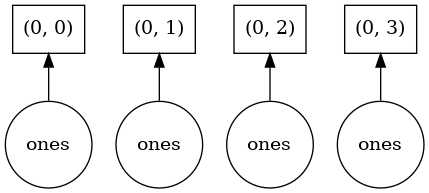

In [7]:
ones.visualize()

Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to reduce the data somehow. For example:

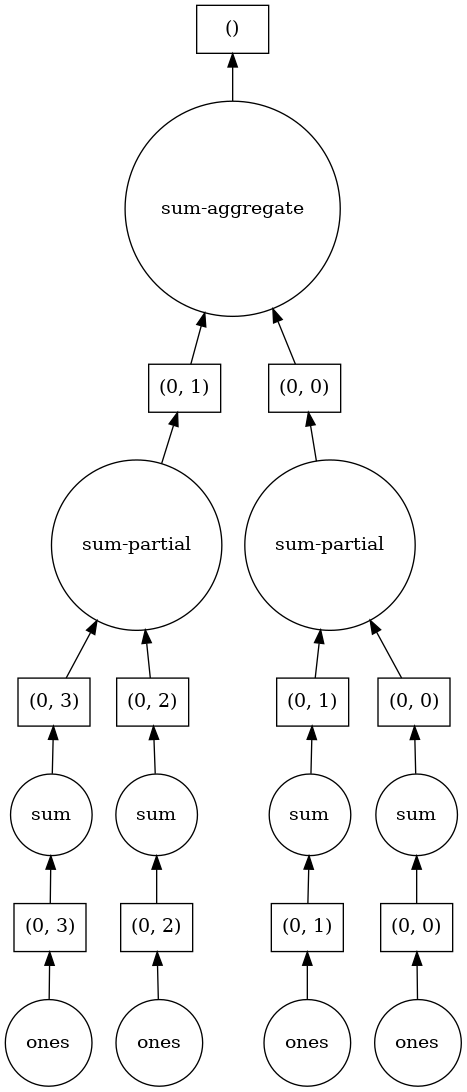

In [8]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data. 

If we make our operation more complex, the graph gets more complex.

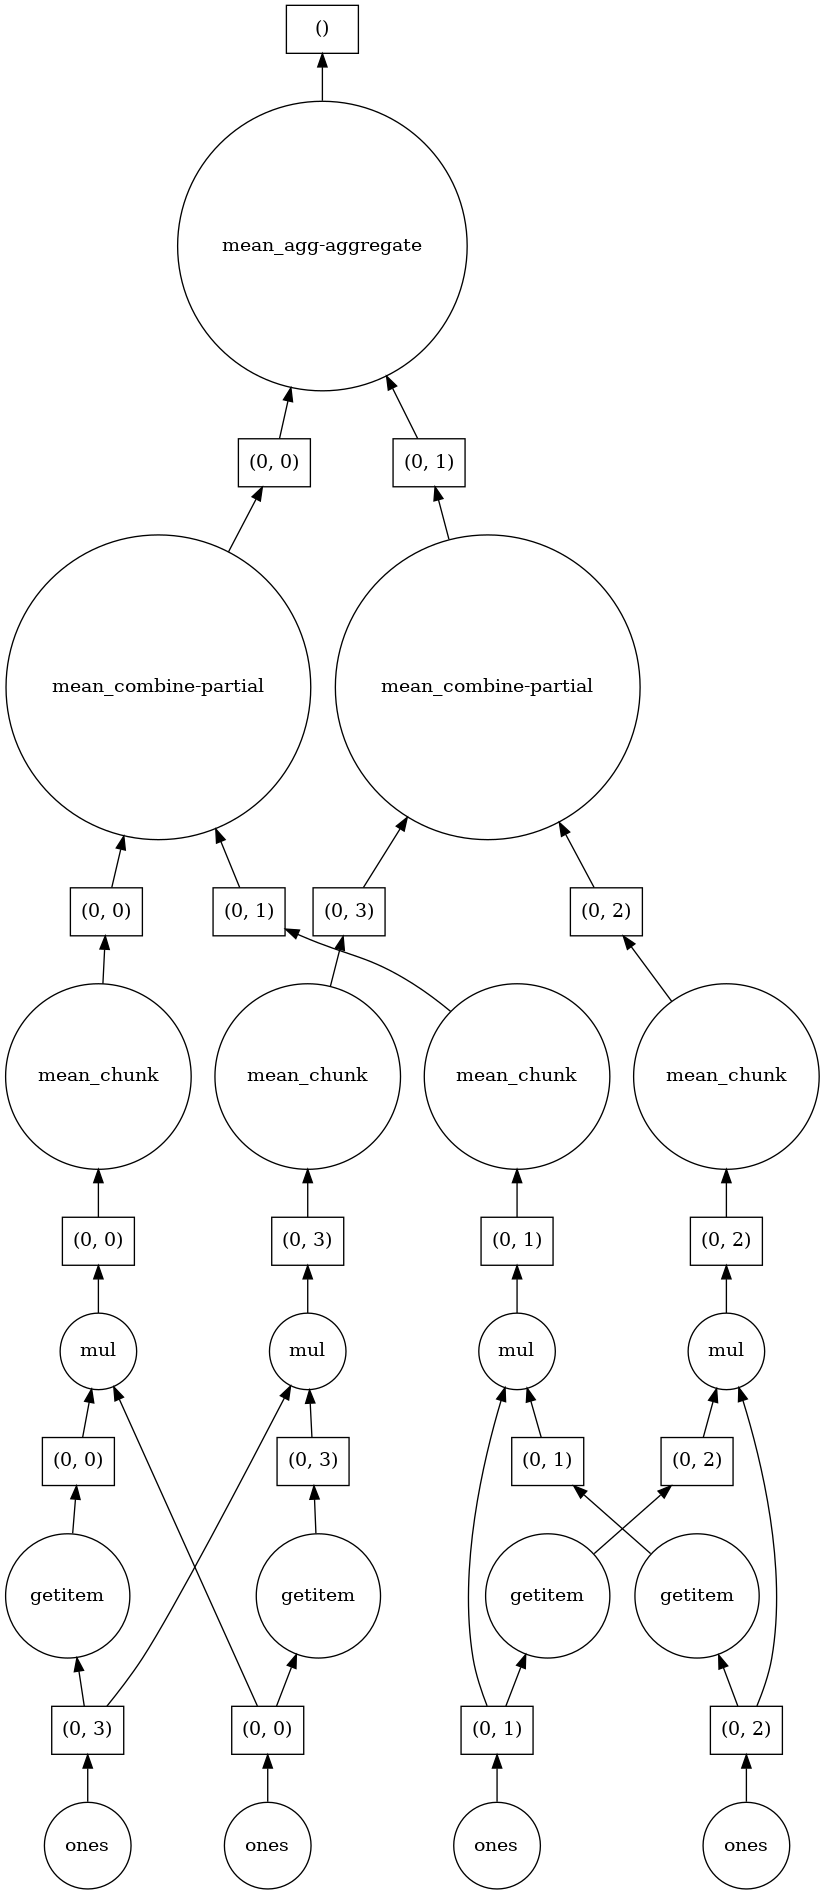

In [9]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (32 MB) is nowhere nearly big enough to warrant the use of dask.

We can make it a lot bigger!

In [10]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

,Array,Chunk
Bytes,6.40 GB,8.00 MB
Shape,"(200000, 4000)","(1000, 1000)"
Count,800 Tasks,800 Chunks
Type,float64,numpy.ndarray


In [11]:
print('%.1f MB' % (big_ones.nbytes / 1e6))

6400.0 MB


This dataset is 6.4 GB, rather than 32 MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, dask has no problem working on it.

_Do not try to `.visualize()` this array!_

When doing a big calculation, dask also has some tools to help us understand what is happening under the hood. Let's watch the dashboard again as we do a bigger computation.

In [12]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

result = big_calc.compute()
result

1.0

### Reduction 

All the usual numpy methods work on dask arrays.
You can also apply numpy function directly to a dask array, and it will stay lazy.

In [13]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=1)
big_ones_reduce

,Array,Chunk
Bytes,1.60 MB,8.00 kB
Shape,"(200000,)","(1000,)"
Count,3400 Tasks,200 Chunks
Type,float64,numpy.ndarray


Plotting also triggers computation, since we need the actual values

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

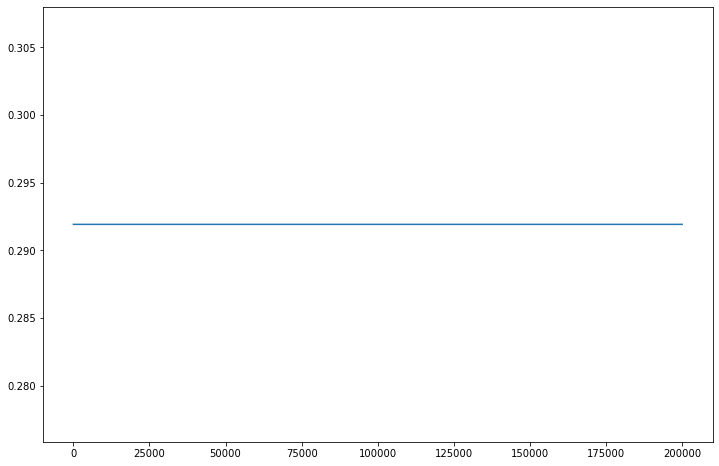

In [15]:
plt.plot(big_ones_reduce)

## Dask Delayed

Dask.delayed is a simple and powerful way to parallelize existing code.  It allows users to delay function calls into a task graph with dependencies.  Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed.  If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

## Create simple functions

These functions do simple operations like add two numbers together, but they sleep for a random amount of time to simulate real work.

In [16]:
import time

def inc(x):
    time.sleep(0.1)
    return x + 1

def dec(x):
    time.sleep(0.1)
    return x - 1
    
def add(x, y):
    time.sleep(0.2)
    return x + y 

We can run them like normal Python functions below

In [17]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 18.5 ms, sys: 1.49 ms, total: 20 ms
Wall time: 401 ms


3

These ran one after the other, in sequence.  Note though that the first two lines `inc(1)` and `dec(2)` don't depend on each other, we *could* have called them in parallel had we been clever.

## Annotate functions with Dask Delayed to make them lazy

We can call `dask.delayed` on our funtions to make them lazy.  Rather than compute their results immediately, they record what we want to compute as a task into a graph that we'll run later on parallel hardware.

In [18]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Calling these lazy functions is now almost free.  We're just constructing a graph

In [19]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 387 µs, sys: 0 ns, total: 387 µs
Wall time: 291 µs


Delayed('add-b984fc88-5f75-4b83-bcf4-d9630c87bc80')

## Visualize computation

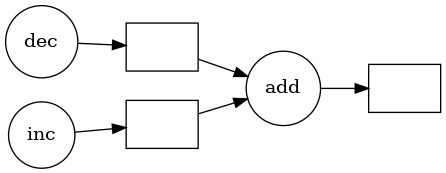

In [20]:
z.visualize(rankdir='LR')

## Run in parallel

Call `.compute()` when you want your result as a normal Python object

If you started `Client()` above then you may want to watch the status page during computation.

In [21]:
%%time
z.compute()

CPU times: user 26.9 ms, sys: 4.68 ms, total: 31.5 ms
Wall time: 316 ms


3

## Parallelize Normal Python code

Now we use Dask in normal for-loopy Python code.  This generates graphs instead of doing computations directly, but still looks like the code we had before.  Dask is a convenient way to add parallelism to existing workflows.

In [22]:
%%time
zs = []
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)
    
zs = dask.persist(*zs)  # trigger computation in the background

CPU times: user 75.7 ms, sys: 13.1 ms, total: 88.8 ms
Wall time: 72 ms


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1295, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1024, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1295, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures